# Project Proposal:  Numerical Study of the Fokker-Planck Equation - Comparison Between Finite Difference Method and Finite Element Method

Rui Ding rd2622

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

# Abstract:

This project aims to apply and analyze different numerical methods to solving the Fokker-Planck Equation which is 
a partial differential equation that describes the time evolution of the probability density function of the velocity of a particle 
under the influence of drag forces and random forces, as in Brownian motion.

The project starts with analyzing the behavior of finite difference method on the simple 1-D constant coefficient Fokker-Planck Equation and do so in the context of 
varying the parameter constants or discretizations in numerically solving the Fokker-Planck PDE. 
The chosen parameters and their implications and interpretations will be discussed.
An error study will be conducted to deterimne the performance of different ways of approximating the derivatives in the 1-D PDE and therefore the order of accuracy of the methods used. 
Stability analysis will be used to tell us what conditions are required for stable solutions and the analysis will be based on CFL conditions with Von Neumann analysis.

Then we will see how Finite Element methods behave with the same sequence of problem settings as above and therefore conclude which method better approximates the solution.

We will use Finite Difference method again to numerically solve some nonconstant coefficient equations and test its performances as an extension of the
family of Fokker-Planck equation problems. In particular, Ornstein-Uhlenbeck process will be used as an example problem.

As for further analysis, a study of generalization to 2-D space can be conducted using similar methods and analysis. 

Finally, the study will discuss the future perspectives of this project.

# Background Introduction-1D Fokker-Planck Equation

In one spatial dimension x, the the stochastic differential equation becomes
$$ dX_{t}=\mu (X_{t},t)dt+\sigma (X_{t},t)dW_{t}$$
with drift $ \mu (X_{t},t) $ and diffusion coefficient $ D(X_{t},t)=\sigma ^{2}(X_{t},t)$, 
the Fokker–Planck equation for the probability density $ p(x,t)$ of the random variable $ X_{t}$ is
$$
{\frac {\partial }{\partial t}}p(x,t)=-{\frac {\partial }{\partial x}}\left[\mu (x,t)p(x,t)\right]+{\frac{1}{2}\frac {\partial ^{2}}{\partial x^{2}}}\left[D(x,t)p(x,t)\right]$$.

This can be written explicitly as: $$\frac{\partial }{\partial t} p(x,t) = -\mu (x,t) \frac{\partial }{\partial x}p(x,t) - p(x,t) \frac{\partial }{\partial x} \mu (x,t) + \frac{p(x,t)}{2} \frac{\partial ^{2}}{\partial x^{2}}D(x,t) + \frac{D(x,t)}{2} \frac{\partial ^{2}}{\partial x^{2}}p(x,t) + \frac{\partial}{\partial x}D(x,t) \frac{\partial}{\partial x} p(x,t) $$.

In the case of constant functional paramters $\mu (x,t) = \mu$ and $D(x,t) = D$, we have a simplified PDE as :
    $$\frac{\partial }{\partial t} p(x,t) = -\mu \frac{\partial }{\partial x}p(x,t) + \frac{D}{2} \frac{\partial ^{2}}{\partial x^{2}}p(x,t)$$.
The constants to be chosen should maintain the fact that p(x,t) is a probability distribution therefore it should sum to 1.

For our below numerical analysis, u(x,t) represents the p(x,t) defined in the Fokker-Planck Equation above as the solution.

# Finite Difference Method - A first approach at the 1-D Fokker-Planck Equation with Gaussian initial conditions.

## Intuitions 

We should notice that when the coefficient $\mu$ in the FPE becomes zero then we obtain what is known as the heat/diffusion equation, and when the coefficient
D is zero then we obtain the advection equation with k = D/2.
Advection Equation: $u_t+au_x = 0$
Diffusion Equation: $u_t = ku_{xx}$
For the Guassian initial data, the advection equation has a solution the drifts away with velocity u and the diffusion equation has a solution that flattens the 
Gaussian probability distribution while maintaining the same center. The true solution for a diffusion equation that is a Guassian centered at zero with initial condition:
$$u(x,0) = \frac{e^{-x^2/{2\sigma^2}}}{\sqrt{2\pi \sigma^2}}$$
is
$$u(x,t) = \frac{e^{-x^2/(2\sigma^2+4kt)}}{\sqrt{2\pi\sigma^2+4\pi kt}}$$
Basically this series of solutions come from a Delta function centered at zero and spreads with variance growing as t. 
The true solution for an advection equation that is a Guassian with initial condition:
$$u(x,0) = \frac{e^{-x^2/{2\sigma^2}}}{\sqrt{2\pi \sigma^2}}$$
is 
$$u(x,t) = u(x-at,0) = \frac{e^{-(x-at)^2/{2\sigma^2}}}{\sqrt{2\pi \sigma^2}}$$

The behavior of both problems is demonstrated below with starting distribution having variance $\sigma^2 = 1$:

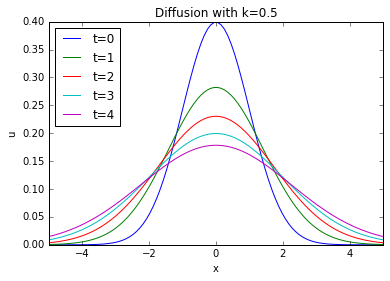

In [128]:

x = np.linspace(-5,5,100)
p_0 = np.exp(-x**2 / 2) / np.sqrt(2*np.pi)
plt.plot(x,p_0,label="t=0")
for t in range(1,5):
    p_true = np.exp(-x**2 / (2*(1+t))) / np.sqrt(2*np.pi*(1+t))
    plt.plot(x,p_true,label="t="+str(t))
plt.xlim(-5,5)
plt.title("Diffusion with k=0.5")
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("u")
plt.show()

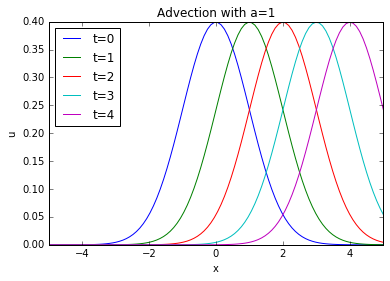

In [6]:
x = np.linspace(-5,5,100)
p_0 = np.exp(-x**2 / 2) / np.sqrt(2*np.pi)
plt.plot(x,p_0,label="t=0")
for t in range(1,5):
    p_true = np.exp(-(x-t)**2 / 2) / np.sqrt(2*np.pi)
    plt.plot(x,p_true,label="t="+str(t))
plt.xlim(-5,5)
plt.title("Advection with a=1")
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("u")
plt.show()

## Explicit Forward in Time Centered in Space Method 

In the cell below, a demonstration of finite difference method on a chosen domain is shown where various input parameters can be tested.
The input parameters include the location of the domain [a, b], the time T from the starting time $t_0$ till iteration ends, number of time steps n, domain discretization parameter m,
constants for $\mu$ and D, as well as the initial distribution. 
For the initial distribution we can initiate with a Gaussian distribution, while the mean can be set at the center of our domain usually chosen to be zero, and the variance 
can be chosen to be 1 so that it mimics a drift with $t_0 = 1/D$ from a delta function located at $x = -\mu*t_0$. We expect the solution to be a combination of the behaviors
from both the advection and the diffusion equations.

$$u(x,0) = \frac{e^{-x^2/2}}{\sqrt{2\pi}}$$

To observe the impact of the drag/diffusion coefficients we can run the method with varied inputs, see below for examples.

$$U_j^{i+1} = U_j^i - \frac{\mu \Delta t}{2\Delta x}(U_{j+1}^i - U_{j-1}^i) + \frac{D\Delta t}{2\Delta x^2}(U_{j+1}^i - 2U_j^i + U_{j-1}^i)$$

This Finite Difference Method employs an explicit forward Euler scheme for time stepping and sets the boundary conditions every time to be the true
solution at those boundary points in time. For every iteration, it uses a centered in space approximation to estimate $p_x$ and $p_{xx}$.


In [8]:

#Solving p_t = -(up)_x + 0.5(Dp)_xx where u,D are supposed to be constant inputs, can be later generalized to functionals

def solve_fpe(m, n, T, u, D, a, b):
    """
    This function solves a constant coefficient 1D fpe with drag coefficient u and diffusion coefficient D using explicit FTCS method.
    The spatial interval is [a,b] and the time range is [0,T]
    m grids and n steps are used for spatial and time discretizations.
    The funciton returns the end time numerical solution p_cur and the spatial array x.
    """
    x = np.linspace(a, b, m+1)
    delta_x = float(b - a) / m
    delta_t = float(T) / n
    mean = (a + b)/2.0
    t_0 = 1.0 / D
    p_0 = np.exp(-(x-mean)**2 / 2) / np.sqrt(2*np.pi)
    t =0.0
    p_cur = p_0
    y_upper = float(max(p_0)+0.01)
    plt.plot(x, p_cur, label='t = '+str(t))
    for j in range(1,n+1):
        
        t = j*delta_t
        p_old = p_cur.copy()
        p_cur[0] = np.exp(-(a-mean-u*t)**2 / (2*D*(t+t_0))) / np.sqrt(2*np.pi*D*(t+t_0))
        p_cur[-1] = np.exp(-(b-mean-u*t)**2 / (2*D*(t+t_0))) / np.sqrt(2*np.pi*D*(t+t_0))
        for i in range(1,m):
            #centered difference
            p_cur[i] = (-u*(p_old[i+1]-p_old[i-1])/(2*delta_x) + D*0.5*(p_old[i-1] - 2*p_old[i] + p_old[i+1])/delta_x**2)*delta_t + p_old[i]
        if j%(n/10) == 0:
            
            plt.plot(x, p_cur, label='t = '+str(t))
            print "Time "+str(t)+" probability total = "+str(sum(p_cur)*delta_x)
    plt.xlabel("x")
    plt.xlim(a,b)
    plt.ylabel("u(x)")
    plt.ylim(0,y_upper)
    plt.legend(loc='upper left')
    plt.title("FPE with $\mu$="+str(u)+" D="+str(D)+" in "+str([a,b]))
    plt.show()
   
    return p_cur, x


As for a first test case we try the above function within the interval [-5,5] with coefficients $\mu$ = 5 and D = 1.(In the test problems we chose
to center at zero so the initial gaussian has mean zero to compare with a true solution, but the function can take whatever interval inputs in principal)
The initial condition is $$u(x,0) = \frac{e^{x^2/2}}{\sqrt{2\pi}}$$
and the true solution is $$u(x,t) = \frac{e^{(x-\mu*t)^2/2(1+t*D)}}{\sqrt{2\pi (1+t*D)}}$$
The chosen number of points in space is 100 and the chosen end time is 1.0. Fo stability purpose we choose a number of iterations of 100.

Time 0.1 probability total = 0.999996021138
Time 0.2 probability total = 0.999947504
Time 0.3 probability total = 0.999509730718
Time 0.4 probability total = 0.996918601407
Time 0.5 probability total = 0.986603055782
Time 0.6 probability total = 0.957502529131
Time 0.7 probability total = 0.896205852207
Time 0.8 probability total = 0.795328889935
Time 0.9 probability total = 0.660623301561
Time 1.0 probability total = 0.510031017998


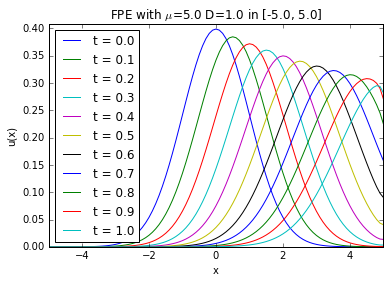

Error at end time = 0.0281879300911


In [5]:
####test case
a=-5.0
b=5.0
L = b-a
m = 100
n = 100
T = 1.0
u = 5.0
D = 1.0
p_cur,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2*D*(1+T))) / np.sqrt(2*D*np.pi*(1+T))
print "Error at end time = "+str(np.linalg.norm((x[1]-x[0])*(p_cur-p_true),ord=1))

The above method should satisfy the probability distribution property of having a total sum of probability 1 on the entire real line
(when we make the domain of distribution large enough).
Here the probability mass drifts out of the boundary of our interval so that the probability total is decreased. The behavior of constant coefficient 
Fokker Planck Equation is a Brownian drift process when the initial condition is a standard normal.


Observing the trend of the probability distribution we can say that in terms of constant coefficients, $\mu$ serves indeed as the drag coefficient that pushes 
the solution to the right when being positive, and D serves as the diffusion coefficient that lets the solution spread and flattens over time.
Both coefficients have to be small to keep the solution mass in the boundary if our boundary is not large enough.

## Stability Analysis

In fact our parameters here does not behave well when diffusion happens too fast, due to the fact that the $\Delta t,\Delta x$ of our method
need to satisfy the CFL condition to make the method stable.
Therefore for different problems we would like to apply different number of points/iterations for the solution to make sense.

For example in the below case if we have L = 10, m = 100, T = 1, n = 100, so $\Delta x = 0.1$, $\Delta t = 0.01$.We will observe severe oscillation in
the solution as it evolves in time, while we matintain the coefficients at $\mu = 5$, D = 10.

Time 0.1 probability total = 329.664483827
Time 0.2 probability total = 6.52870531165e+14
Time 0.3 probability total = 2.10794155578e+27
Time 0.4 probability total = 8.23023778068e+39
Time 0.5 probability total = 3.55883843403e+52
Time 0.6 probability total = 1.64036835411e+65
Time 0.7 probability total = 7.89910492623e+77
Time 0.8 probability total = 3.92692902265e+90
Time 0.9 probability total = 2.00012822581e+103
Time 1.0 probability total = 1.03835118431e+116


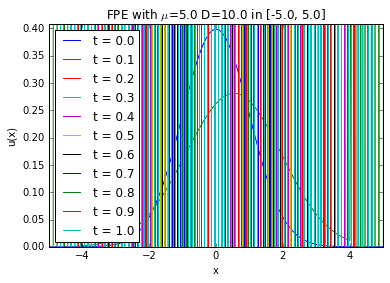

In [24]:
m = 100
n = 100
T = 1.0
u = 5.0
D = 10.0
a = -5.0
b = 5.0
p_cur,x = solve_fpe(m, n, T, u, D, a, b)

Changing to n = 1000 in the above cells show that for the FPE we need to make sure that the CFL condition for the diffusion part of it holds, so as to have the method
to be stable. Recall the for the diffusion equation $$u_t = k u_{xx}$$ we use the centered approximation for the second derivative in x:
    $$U_j^{i+1} = U_j^i + \frac{k\Delta t}{\Delta x^2}(U_{j-1}^i + U_{j+1}^i - 2U_j^i)$$

Writing the Von Neumann Analysis of this method, with $U_j^{i+1} = g(\xi)U_j^i$ and $U_{j+1}^i = U_j^i e^{i\xi \Delta x}$ we get :
    $$g(\xi) = 1+\frac{2k\Delta t}{\Delta x^2}(cos(\theta\Delta x) - 1)$$
    The requirement that $|g(\xi)|<=1$ gives us the CFL condition:
    $$\frac{2k\Delta t}{\Delta x^2} <=1$$
    Here with D = 2k our condition becomes:
        $$\Delta t <=\frac{\Delta x^2}{D}$$

Also we have the CFL condition from the advection equation: $u_t + \mu u_x = 0$
    $$\Delta t <= \frac{\Delta x}{\mu}$$

Now in our test problem with D = 10, $\mu=5$,$\Delta x = 0.1$, so the condition specifies that we need to have $\Delta t <= 0.001$, so n>=1000 given T=1.0, for the method to stabilize.
We can see from the next cell that this condition indeed worksas the solution behaves well.

Time 0.1 probability total = 0.999360196238
Time 0.2 probability total = 0.9903076997
Time 0.3 probability total = 0.961853705502
Time 0.4 probability total = 0.913197359743
Time 0.5 probability total = 0.850217338985
Time 0.6 probability total = 0.779650530228
Time 0.7 probability total = 0.706831927442
Time 0.8 probability total = 0.635386932466
Time 0.9 probability total = 0.567540247098
Time 1.0 probability total = 0.504512984377


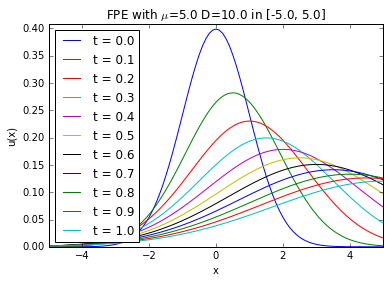

Error at end time = 0.000296950820383


In [25]:
m = 100
n = 1000
T = 1.0
u = 5.0
D = 10.0
a = -5.0
b = 5.0
p_cur,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
print "Error at end time = "+str(np.linalg.norm((x[1]-x[0])*(p_cur-p_true),ord=1))

But as D becomes small the other term with CFL condition $\Delta t<=\frac{\Delta x}{\mu}$ becomes significant. As we can see from the example in the next cell where
we impose D = 0.5 small and u = 10 large.
It is not enough to only have both conditions satisfied as they becomes close, in fact if we satisfy the advection cfl condition with $\Delta t = 0.01$ is in
the case below we still get solutions that doesn't make physical sense. The number n have to be larger to satisfy both parts together. In this case if we
choose $\Delta t = 0.001$ again, then we can get approximate solutions that look right.

Time 0.04 probability total = 0.999997901037
Time 0.08 probability total = 0.999984580583
Time 0.12 probability total = 0.99990876616
Time 0.16 probability total = 0.999560427811
Time 0.2 probability total = 0.998245318423
Time 0.24 probability total = 0.994114291925
Time 0.28 probability total = 0.983206989037
Time 0.32 probability total = 0.958792145334
Time 0.36 probability total = 0.912120306639
Time 0.4 probability total = 0.835435251787


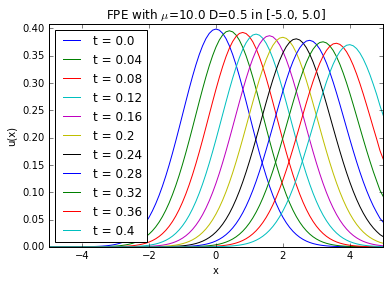

Error at end time = 0.0133043586326


In [26]:
m = 100
n = 400
T = 0.4
u = 10.0
D = 0.5
a = -5.0
b = 5.0
p_cur,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
print "Error at end time = "+str(np.linalg.norm((x[1]-x[0])*(p_cur-p_true),ord=1))

The question is what does the cfl eventually looks like for this kind of problems, with constant $\mu$ and D. Again we apply Von Neumann analysis on our scheme:

$$U_j^{i+1} = U_j^i - \frac{\mu \Delta t}{2\Delta x}(U_{j+1}^i - U_{j-1}^i) + \frac{D\Delta t}{2\Delta x^2}(U_{j+1}^i - 2U_j^i + U_{j-1}^i)$$
    So this gives us:
$$g(\xi) = 1 - \frac{\mu \Delta t}{2\Delta x}(2isin(\xi\Delta x)) + \frac{D\Delta t}{2\Delta x^2}(2cos(\xi\Delta x) - 2)$$

Under the condition that $|g(\xi)|<=1$ we have
$$|1 - \frac{D\Delta t}{\Delta x^2}+\frac{D\Delta t cos(\xi\Delta x)}{\Delta x^2} - i\frac{\mu\Delta t sin(\xi\Delta x)}{\Delta x}|<=1$$
If we choose $\Delta t = \frac{\Delta x^2}{D}$ as from the diffusion CFL condition, then we have to make sure that 
$\frac{D\Delta t}{\Delta x^2}>=\frac{|\mu|\Delta t}{\Delta x}$ for this method to be stable. Doing so implies
that $\Delta t<=\frac{\Delta x}{\mu}$. Therefore when this inequality holds with $\Delta x$ chosen,we better
choose $\Delta t = \frac{\Delta x^2}{D}$ to run our numerical method.

## Error Analysis

For most of the FPE's we do not have a good true solution to compare to, but there are cases where the exact analytical solution is known.
We focus on comparing the numerical results with the true solution in these cases to check our method's order of accuracy.



For example increasing the number of points used with the number of time steps together we can get to very close accuracy for the true probability distribution.
The two cells below run on the same problem with u = 5, D = 1, as long as $\Delta x<=0.2$ we are able to choose $\Delta t = \Delta x^2$ to ensure stability.
We compare the results of m = 100 with m = 1000, the latter clearly having an advantage on accuracy, but runs much slower due to large number of iterations.

Time 0.1 probability total = 0.99999124299
Time 0.2 probability total = 0.999872610781
Time 0.3 probability total = 0.9989493795
Time 0.4 probability total = 0.994473453849
Time 0.5 probability total = 0.97964367148
Time 0.6 probability total = 0.943626748466
Time 0.7 probability total = 0.875935051808
Time 0.8 probability total = 0.773207449398
Time 0.9 probability total = 0.643000975042
Time 1.0 probability total = 0.5013697414


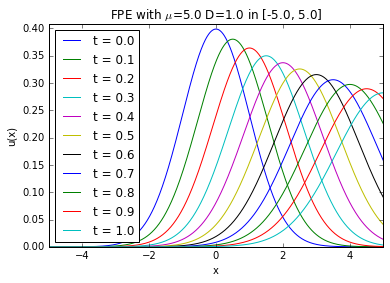

Error at end time = 0.000262566824126


In [27]:
m=1000
a = -5.0
b = 5.0
n=10000
u = 5.0
D = 1.0
T = 1.0
p,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
print "Error at end time = "+str(np.linalg.norm((x[1]-x[0])*(p-p_true),ord=1))


Time 0.1 probability total = 0.999996021138
Time 0.2 probability total = 0.999947504
Time 0.3 probability total = 0.999509730718
Time 0.4 probability total = 0.996918601407
Time 0.5 probability total = 0.986603055782
Time 0.6 probability total = 0.957502529131
Time 0.7 probability total = 0.896205852207
Time 0.8 probability total = 0.795328889935
Time 0.9 probability total = 0.660623301561
Time 1.0 probability total = 0.510031017998


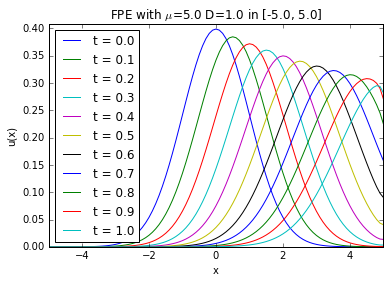

Error at end time = 0.0281879300911


In [28]:
m=100
a = -5.0
b = 5.0
n=100
u = 5.0
D = 1.0
T = 1.0
p,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
print "Error at end time = "+str(np.linalg.norm((x[1]-x[0])*(p-p_true),ord=1))

Now we perform an order of accuracy study on this problem with u = 5 and D = 1 on [-5,5], using m = 100,200,300,400,500 points and holding
the rule that $\Delta t = \frac{\Delta x^2}{D} = \Delta x^2$. Reusing the code from above but without the plotting part. 

In [5]:
def solve_fpe(m, n, T, u, D, a, b):
     """
    This function solves a constant coefficient 1D fpe with drag coefficient u and diffusion coefficient D using explicit FTCS method.
    The spatial interval is [a,b] and the time range is [0,T]
    m grids and n steps are used for spatial and time discretizations.
    The funciton returns the end time numerical solution p_cur and the spatial array x.
    """
    x = np.linspace(a, b, m+1)
    delta_x = float(b - a) / m
    delta_t = float(T) / n
    mean = (a + b)/2.0
    t_0 = 1.0 / D
    p_0 = np.exp(-(x-mean)**2 / 2) / np.sqrt(2*np.pi)
    t =0.0
    p_cur = p_0
    y_upper = float(max(p_0)+0.01)
    
    for j in range(1,n+1):
        
        t = j*delta_t
        p_old = p_cur.copy()
        #holding the boundary conditions using the true solution
        p_cur[0] = np.exp(-(a-mean-u*t)**2 / (2*D*(t+t_0))) / np.sqrt(2*np.pi*D*(t+t_0))
        p_cur[-1] = np.exp(-(b-mean-u*t)**2 / (2*D*(t+t_0))) / np.sqrt(2*np.pi*D*(t+t_0))
        for i in range(1,m):
            #centered difference for first and second derivative
            p_cur[i] = (-u*(p_old[i+1]-p_old[i-1])/(2*delta_x) + D*0.5*(p_old[i-1] - 2*p_old[i] + p_old[i+1])/delta_x**2)*delta_t + p_old[i] 
    return p_cur, x

IndentationError: unindent does not match any outer indentation level (<ipython-input-5-2d92bc3eafe5>, line 8)

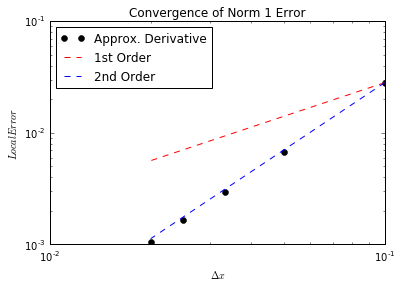

In [6]:
a = -5.0
b = 5.0
u = 5.0
D = 1.0
T = 1.0
#convergence plot
delta_x = []
error = []
for m in [100,200,300,400,500]:
    n = int(m*m / 100)
    dx = (b-a) / m
    p,x = solve_fpe(m, n, T, u, D, a, b)
    delta_x.append(dx)
    p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
    e = np.linalg.norm(dx*(p - p_true),ord=1)
    error.append(e)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
delta_x = np.array(delta_x)
error = np.array(error)
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

order_C = lambda delta_x, error, order: np.exp(np.log(error) - order * np.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc='upper left')
axes.set_title("Convergence of Norm 1 Error")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$Local Error$")


plt.show()

From the previous cell result we conclude that the FTCS explicit method we used for this problem is second order accurate in $\Delta x$, which means it is
first order accurate in $\Delta t$ since we chose $\Delta t = \Delta x^2$. This result is expected of a Centered in Space scheme.
We can look at this problem solved on a larger interval on a shorter time, but maintaining the same $\Delta x,\Delta t$ discretization as before.
This enables us to look at basically the entire mass of the probability distribution. The numerical solution approximates the true solution closely except
at the probability peak. The total probablity is well maintained at one in this case because of the large domain.

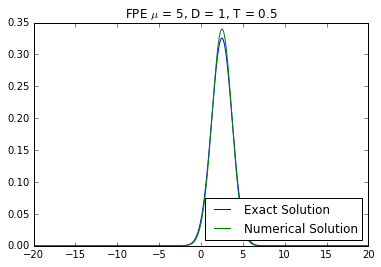

Error at end time = 0.042288245303
Sum of probability at end time = 1.0


In [19]:
m=400
a = -20.0
b = 20.0
n=50
u = 5.0
D = 1.0
T = 0.5
#plot end time behavior
p,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
delta_x = (b-a)/m
plt.plot(x,p_true,label='Exact Solution')
plt.plot(x,p,label='Numerical Solution')
plt.legend(loc=4)
plt.title("FPE $\mu$ = 5, D = 1, T = 0.5")
plt.show()
print "Error at end time = "+str(delta_x*np.linalg.norm(p-p_true,ord=1))
print "Sum of probability at end time = "+str(sum(p*delta_x))

At last we can use a Modified Equation Analysis to check what the LTE term indeed looks like. For our explicit FTCS method:
$$U_j^{i+1} = U_j^i - \frac{\mu \Delta t}{2\Delta x}(U_{j+1}^{i} - U_{j-1}^{i}) + \frac{D\Delta t}{2\Delta x^2}(U_{j+1}^i - 2U_j^i + U_{j-1}^i)$$
We replace $U_j^i$ with the solution it approximates, u(x,t), $U_j^{i+1}$ with $u(x,t+\Delta t)$, and $U_{j+1}^i,U_{j-1}^i$ with $u(x+\Delta x,t),u(x-\Delta x,t)$
The LTE is:
$$\tau^n = \frac{u(x,t+\Delta t) - u(x,t)}{\Delta t} + \frac{\mu }{2\Delta x}(u(x+\Delta x,t)-u(x-\Delta x,t)) - \frac{D}{2\Delta x^2}(u(x+\Delta x,t)-2u(x,t)+u(x-\Delta x,t))$$

Using the Taylor expansion approximations to the stepped solutions:
$$u(x,t+\Delta t) \approx u(x,t)+\Delta t u_t+\frac{\Delta t^2}{2}u_{tt}...$$
$$u(x+\Delta x,t) \approx u(x,t)+\Delta x u_x+\frac{\Delta x^2}{2}u_{xx}+\frac{\Delta x^3}{6}u_{xxx}+\frac{\Delta x^4}{24}u_{xxxx}...$$
$$u(x-\Delta x,t) \approx u(x,t)-\Delta x u_x+\frac{\Delta x^2}{2}u_{xx}-\frac{\Delta x^3}{6}u_{xxx}+\frac{\Delta x^4}{24}u_{xxxx}...$$
                                                                                                                             

$$\tau^n \approx u_t + \frac{\Delta t}{2}u_{tt}+O(\Delta t^2) + \frac{\mu}{2\Delta x}(2\Delta x u_x+O(\Delta x^3)) - \frac{D}{2\Delta x^2}(\Delta x^2 u_{xx}+O(\Delta x^4))$$
$$\tau^n \approx u_t + \mu u_x - \frac{D}{2}u_{xx} + O(\Delta t)+O(\Delta x^2)$$

Now since the original problem we are modelling is $u_t = -\mu u_x + \frac{D}{2}u_{xx}$, and we have the chosen discretization such that
$O(\Delta t) = O(\Delta x^2)$, the LTE of this method is indeed second order in $\Delta x$ and first order in $\Delta t$. This result confirms our numerical error analysis.

## Implicit Method

On the below problem with $\Delta x = 0.1,\Delta t = 0.01,D = 1,\mu = 2$, we can test an partially implicit method against the explicit FTCS method we
developed earlier. As an example, I wrote a code that takes the scheme:
$$U_j^{i+1} = U_j^i - \frac{\mu \Delta t}{2\Delta x}(U_{j+1}^{i+1} - U_{j-1}^{i+1}) + \frac{D\Delta t}{2\Delta x^2}(U_{j+1}^i - 2U_j^i + U_{j-1}^i)$$

The method takes an implicit advection component and an explicit diffusion component. In numerically running this scheme, sparse matrices
are used to evaluate the left and right hand side, also we impose the boundary conditions and the initial condition as before.(In the test problems we chose
to center at zero so the initial gaussian has mean zero to compare with a true solution, but the function can take whatever interval inputs in principal):
$$u(x,0) = \frac{e^{-x^2/2}}{\sqrt{2\pi}}$$
(The interval is centered at zero.)
The boundary conditions are imporsed as:
$$u(a,t) = \frac{e^{(a-\mu*t)^2/2(1+t*D)}}{\sqrt{2\pi (1+t*D)}}$$
$$u(b,t) = \frac{e^{(b-\mu*t)^2/2(1+t*D)}}{\sqrt{2\pi (1+t*D)}}$$

The original explicit method runs in the cell below and it gives an error of 0.0099. Notice that the CFL condition holds for those parameters.

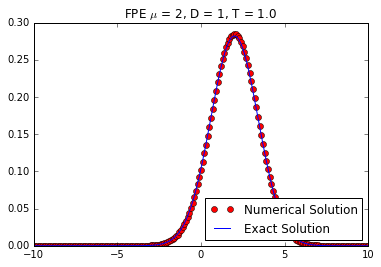

Error at end time = 0.00994323965554


In [18]:
#explicit method solution
a=-10.0
b=10.0
L = b-a
m = 200
n = 100
T = 1.0
u = 2.0
D = 1.0
p_cur,x = solve_fpe(m, n, T, u, D, a, b)
p_true = np.exp(-(x-u*T)**2 / (2*D*(1+T))) / np.sqrt(2*D*np.pi*(1+T))
plt.plot(x,p_cur,'ro',label='Numerical Solution')
plt.plot(x,p_true,'b',label='Exact Solution')

plt.legend(loc=4)
plt.title("FPE $\mu$ = 2, D = 1, T = 1.0")
plt.show()
print "Error at end time = "+str(np.linalg.norm((x[1]-x[0])*(p_cur-p_true),ord=1))

Now we use the new function for an advection implicit method. The cell below runs this test problem and the generated error is 0.01, the same orer of
accuracy for both methods on this problem.

In [33]:
def FPE_Implicit_Advec(a,b,T,m,n,u,D):
     """
    This function solves a constant coefficient 1D fpe with drag coefficient u and diffusion coefficient D using advection implicit method.
    The spatial interval is [a,b] and the time range is [0,T]
    m grids and n steps are used for spatial and time discretizations.
    The funciton returns the end time numerical solution array.
    """
    mean = (a+b)/2.0
    x = np.linspace(a, b, m)
    delta_x = (b-a) / (m-1)

    t = np.linspace(0.0, T, n+1)
    delta_t = T/n

    U = np.empty((n + 1, m))

    # Initial and boundary conditions
    U[0, :] = np.exp(-(x-mean)**2 / 2) / np.sqrt(2*np.pi)

    # Build solving matrix
    r = np.ones(m) * k * delta_t / (delta_x**2)
    s =  np.ones(m) * u * delta_t / (2*delta_x)
    A = sparse.spdiags([-s, np.ones(m) , s], [-1, 0, 1], m, m).tocsr()
    B = sparse.spdiags([r, 1.0 - 2.0 * r, r], [-1, 0, 1],  m, m).tocsr()

    # Time stepping 
    for n in xrange(len(t)-1):
        # Construct right-hand side
        t_c = delta_t * (n)
        rhs = B.dot(U[n, :])
        rhs[0] += (np.exp(-(a-mean-u*t_c)**2 / (2+4*k*t_c)) / np.sqrt((2+4*k*t_c)*np.pi))*k*delta_t / (delta_x**2) 
        rhs[-1] += (np.exp(-(b-mean-u*t_c)**2 / (2+4*k*t_c)) / np.sqrt((2+4*k*t_c)*np.pi))*k*delta_t / (delta_x**2)
        t_c = t_c+delta_t
        # Solve system
        U[n+1, :] = linalg.spsolve(A, rhs)
        
    return U[-1,:]


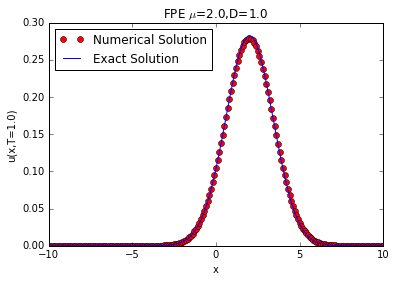

Error at end time = 0.0100923809995


In [34]:
m=201
a = -10.0
b = 10.0
n=100
u = 2.0
D = 1.0
k = D/2.0
T = 1.0
delta_x = (b-a)/(m-1)
x = np.linspace(a,b,m)
#advection implicit method test
U = FPE_Implicit_Advec(a,b,T,m,n,u,D)
u_true = np.exp(-(x-u*T)**2 / (2+4*k*T)) / np.sqrt((2+4*k*T)*np.pi)  
# Plot a few solutions
plt.plot(x,U,'ro',label='Numerical Solution')
plt.plot(x,u_true,'b',label='Exact Solution')
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("u(x,T=1.0)")
plt.title("FPE $\mu$="+str(u)+",D="+str(D))
plt.show()
print "Error at end time = "+str(np.linalg.norm(delta_x*(u_true-U),ord=1))

Again we run an order of accuracy testing on the number of cells($\Delta x$), while maintaining the CFL condition in choosing $\Delta t = \Delta x^2$:

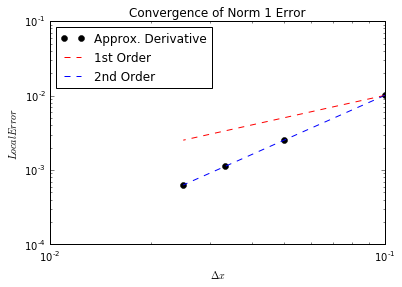

In [16]:
a = -10.0
b = 10.0
u = 2.0
D = 1.0
T = 1.0
delta_x = []
error = []
#plot convergence of advection implicit method
for m in [200,400,600,800]:
    n = int(m*m / 400)
    dx = (b-a) / m
    x = np.linspace(a,b,m+1)
    U = FPE_Implicit_Advec(a,b,T,m+1, n, u, D)
    delta_x.append(dx)
    u_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
    e = np.linalg.norm(dx*(U-u_true),ord=1)
    error.append(e)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
delta_x = np.array(delta_x)
error = np.array(error)
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

order_C = lambda delta_x, error, order: np.exp(np.log(error) - order * np.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc='upper left')
axes.set_title("Convergence of Norm 1 Error")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$Local Error$")


plt.show()

This implicit method is also second order in space ($\Delta x$) and therefore first order in time ($\Delta t$)

Using Von Neumann Analysis we might get an insight as to why this choice of $\Delta t,\Delta x$ works.Starting with the scheme:
$$U_j^{i+1} = U_j^i - \frac{\mu \Delta t}{2\Delta x}(U_{j+1}^{i+1} - U_{j-1}^{i+1}) + \frac{D\Delta t}{2\Delta x^2}(U_{j+1}^i - 2U_j^i + U_{j-1}^i)$$
$$g(\xi)(1+\frac{\mu \Delta t}{2\Delta x}(2isin(\xi\Delta x)))= 1+\frac{D\Delta t}{2\Delta x^2}(2cos(\xi\Delta x)-2)$$
Since $|1+\frac{\mu \Delta t}{2\Delta x}(2isin(\xi\Delta x))|>=1$ always, for $|g(\xi)|<=1$ it would be sufficient if $|1+\frac{D\Delta t}{2\Delta x^2}(2cos(\xi\Delta x)-2)|<=1$ is satisfied, 
which is exactly the CFL condition for Diffusion Equation using FTCS approximation. The condition simplifies to $\Delta t<=\frac{\Delta x^2}{D}$ which is the discretization we chose in the above problems.
Thus the solution is guaranteed to be stable.


Again we can use a Modified Equation Analysis to check what the LTE term indeed looks like. For our advection implicit FTCS method:
$$U_j^{i+1} = U_j^i - \frac{\mu \Delta t}{2\Delta x}(U_{j+1}^{i+1} - U_{j-1}^{i+1}) + \frac{D\Delta t}{2\Delta x^2}(U_{j+1}^i - 2U_j^i + U_{j-1}^i)$$
We replace $U_j^i$ with the solution it approximates, u(x,t), $U_j^{i+1}$ with $u(x,t+\Delta t)$, and $U_{j+1}^i,U_{j-1}^i$ with $u(x+\Delta x,t),u(x-\Delta x,t)$
and $U_{j+1}^{i+1},U_{j-1}^{i+1}$ with $u(x+\Delta x,t+\Delta t),u(x-\Delta x,t+\Delta t)$.
The LTE is:
$$\tau^n = \frac{u(x,t+\Delta t) - u(x,t)}{\Delta t} + \frac{\mu }{2\Delta x}(u(x+\Delta x,t+\Delta t)-u(x-\Delta x,t+\Delta t)) - \frac{D}{2\Delta x^2}(u(x+\Delta x,t)-2u(x,t)+u(x-\Delta x,t))$$
Using the Taylor expansion approximations to the stepped solutions we wrote before and the new terms:
$$u(x+\Delta x,t+\Delta t) \approx u(x,t+\Delta t)+\Delta x u_x(x,t+\Delta t)+\frac{\Delta x^2}{2}u_{xx}(x,t+\Delta t)+\frac{\Delta x^3}{6}u_{xxx}(x,t+\Delta t)$$

$$u(x-\Delta x,t+\Delta t) \approx u(x,t+\Delta t)-\Delta x u_x(x,t+\Delta t)+\frac{\Delta x^2}{2}u_{xx}(x,t+\Delta t)-\frac{\Delta x^3}{6}u_{xxx}(x,t+\Delta t)$$

We have that 
$$u(x+\Delta x,t+\Delta t) - u(x-\Delta x,t+\Delta t) \approx 2\Delta x (u_x(x,t)+\Delta t u_{xt}(x,t)+O(\Delta t^2)
                                    +2\frac{\Delta x^3}{6}(u_{xxx}(x,t)+\Delta t u_{xxxt}(x,t)+O(\Delta t^2))$$
$$\tau^n \approx u_t + \frac{\Delta t}{2}u_{tt} + \mu(u_x+\Delta t u_{xt}) - \frac{D}{2}u_{xx}+O(\Delta t^2)+O(\Delta x^2)$$    
                                                                        

By checking the LTE we find again for the equation $u_t = -\mu u_x + \frac{D}{2}u_{xx}$ this method approximates the solution to $O(\Delta t)$ in time and $O(\Delta x^2)$ in space.

# Finite Element Method

We would again run the numerical solutions of some of the above problems with finite element method.
For the time being it is quite hard to implement FEM on the complete FPE so I choose to evaluate its performance on the FPE with zero drift,which
represents a Brownian motion in 1D. The FEM for such a heat equation basically involves setting up a family of basis functions and solving it in the weak sense:
integral of $ V u_t $ = integral of $V u_{xx}$ for any V function.

I found some codes online thanks to the contribution of https://people.sc.fsu.edu/~jburkardt/py_src/py_src.html. The codes I modified from the sample codes
    are in FEM.py and it solves a 1D heat problem with given initial and boundary conditions on an interval using Finite Element Method.
The basis functions used by this code is the hat/tent functions define over the given x interval. There are a number of m basis functions where m is
the number of cells used to discretize the space. The system that the code solves is 
$$Mass*\frac{du}{dt} = -A*u + b$$ where the matrices and column vectors
are constructed in the code. 

Now let's compare the results of FEM and FDM on some input tests for heat equation problems.
The first test is a standard gaussian distribution initial condition for which the true solution we have mentioned before, the interval is [-5,5] with m=100 n=400, k=1(D=2), and T=0.5.

### Test 1 Normal Initial Condition

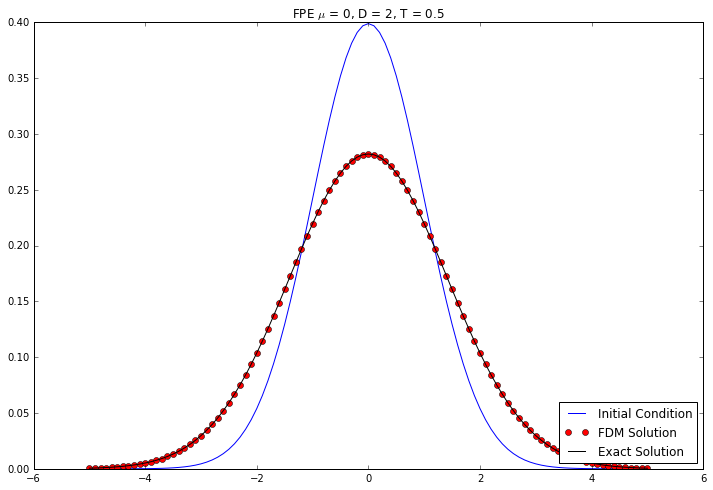

Error at end time = 7.07489276145e-05
Sum of probability at end time = 0.999642826114


In [17]:
##FDM
m=100
a = -5.0
b = 5.0
n=400
u = 0
D = 2.0
T = 0.5

p,x = solve_fpe(m, n, T, u, D, a, b)
p_0 = np.exp(-x**2 / 2) / np.sqrt(np.pi*2)
plt.figure(figsize = (12,8))
plt.plot(x,p_0,'b',label='Initial Condition')
p_true = np.exp(-(x-u*T)**2 / (2+2*D*T)) / np.sqrt(np.pi*(2+2*D*T))
delta_x = (b-a)/m
plt.plot(x,p,'ro',label='FDM Solution')
plt.plot(x,p_true,'k',label='Exact Solution')
plt.legend(loc=4)
plt.title("FPE $\mu$ = 0, D = 2, T = 0.5")

plt.show()
print "Error at end time = "+str(delta_x*np.linalg.norm(p-p_true,ord=1))
print "Sum of probability at end time = "+str(sum(p*delta_x))

The image below is generated by FEM.py code on the same input parameters.

![FEM](fem1dheat_gauss2.png)

For this problem, we hold the CFL for diffusion equation which is $\Delta t<=\frac{\Delta x^2}{2k} = \frac{\Delta x^2}{D}$. The above cell shows the result
of our FTCS method giving an LTE of 7e-5 in the end. The FEM scheme gives 5.2e-5 error term but its process time is way longer. Notice that here we choose
a small enough time step because although the CFL condition is enough for the FDM to work stably and converge to the true solution, the FEM requires
much stricter bound for it to not only be stable but give meaningful results. We run another test problem with a uniformly distributed initial condition
and the boundary condition to be fixed at zero. For this problem we first test the FDM with explicit centered difference approximation.

### Test 2 Uniform Initial Condition

For a diffusion problem that has fixed boundary conditions of zero at both ends, we can use the Fourier series to approximate its true solution.
For example here on the interval [0,L] we have $$u_t = k u_{xx}, u(0,t) = u(L,t) = 0, u(x,0) = c$$
The solution is the sum of the node solutions: $$u_n(x,t) = A_n sin(\frac{n\pi (x)}{L}) e^{-n^2\pi^2 t/L^2}$$ for n = 1,2,3...
Using the Fourier transform we can get the coefficients as $A_n = \frac{4c}{n\pi}$ so we can choose to truncate at a small enough
truncation error for the real solution series to get an approximate true solution to compre to.

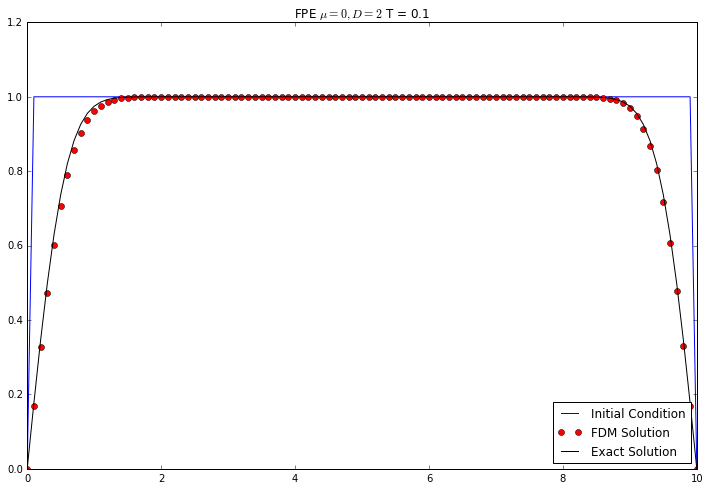

Error at end time = 0.0399213246658


In [7]:
#finite difference method on test2
m=100
a = 0.0
b = 10.0
L = b-a
dx = L/m
x = np.linspace(a,b,m+1)
n=100
k = 1.0
T = 0.1
dt = T/n
c = 1.0
p_0 = c*np.ones(m+1)
p_0[0] = 0.0
p_0[-1] = 0.0
plt.figure(figsize = (12,8))
plt.plot(x,p_0,'b',label='Initial Condition')
t= 0.0
p_cur = p_0.copy()
for j in range(1,n+1):
    for i in range(1,m):
        p_cur[i]+=(k*dt/dx**2)*(p_cur[i+1]+p_cur[i-1]-2*p_cur[i])
    p_cur[0] = 0.0
    p_cur[-1] = 0.0
p_true = (4*c/np.pi)*np.sin(np.pi*(x-a)/L)*np.exp(-k*T*np.pi**2/L**2)
for i in range(1,17):
      n = 2*i+1
      p_true+=(4*c/(n*np.pi))*np.sin(n*np.pi*(x-a)/L)*np.exp(-k*T*n**2*np.pi**2/L**2)

plt.plot(x,p_cur,'ro',label='FDM Solution')
plt.plot(x,p_true,'k',label='Exact Solution')
plt.legend(loc=4)
plt.title("FPE $\mu=0,D=2$ T = 0.1")

plt.show()
print "Error at end time = "+str(dx*np.linalg.norm(p_cur-p_true,ord=1))


The FEM code takes the same inputs and parameters and gives an erro of 0.06 upon end time T = 0.1. The plot is shown below:
![FEM2](femtest2.png)

We know from previous analysis that the explicit FTCS method on this problem is second order accurate in $\Delta x$.
We can run an error analysis for the FEM in this case. In the code I choose $\Delta t = \Delta x^2$ but the coefficient attached to it is 1/10 to ensure convergence.
So when n(number of time steps) gets large it become very inefficient using the FEM method. For m = [100,200,300], the norm 1 error produced by the FEM method is
[0.0607,0.0318,0.0215]. The order of accuracy plot looks like:

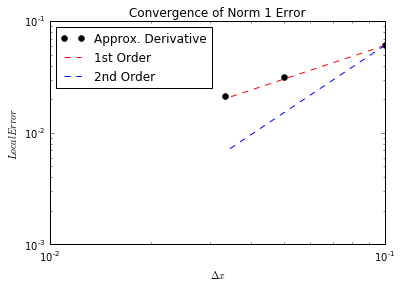

In [10]:
#Finite Element error convergence plot
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
delta_x = np.array([10.0/100,10.0/200,10.0/300])
error = np.array([0.0607,0.0318,0.0215])
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

order_C = lambda delta_x, error, order: np.exp(np.log(error) - order * np.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc='upper left')
axes.set_title("Convergence of Norm 1 Error")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$Local Error$")
plt.show()

Clearly the Finite Element Method produces first order accurate solutions in this test problem in terms of $\Delta x$. So its overall performance on the
heat equation problems(a special case of FPE)is limited by its accuracy and efficiency compared with the Finite Difference Methods.

From my observation it is clear that Finite Element Method requires much smaller time steps to make sure that the solution converges to true solution.
When we go to higher dimensional problems, this factor can be more significant as the CFL condition for diffusion equation is not enough for FEM,
the behavior of $\Delta t$ might as well go as $O(\Delta x^3)$ to reach an accurate numerical solution.

# Nonconstant Coefficients Fokker-Planck Equation

So far we have considered problems with constant $\mu$ and D. 
Another key aspect is applying nonlinear $\mu(x)$ and D(x) functions in the fokker-planck equation. This would involve again approximating their derivatives at each grid point.


First let's recall the original PDE once we insert back nonconstant functions $\mu(x)$ and D(x).(Replacing p(x,t) with u(x,t) in its original definition)

$$
{\frac {\partial }{\partial t}}u(x,t)=-{\frac {\partial }{\partial x}}\left[\mu (x,t)u(x,t)\right]+{\frac{1}{2}\frac {\partial ^{2}}{\partial x^{2}}}\left[D(x,t)u(x,t)\right]$$

We can treat the function $\mu(x,t)u(x,t),D(x,t)u(x,t)$ as their own functions which take the values $\mu_j^i U_j^i, D_j^i U_j^i$ at a discrete point j at time i.Therefore
a Centered in Space explicit approximation would give :
$$(\mu(x,t)u(x,t))_x \approx \frac{\mu_{j+1}^i U_{j+1}^i - \mu_{j-1}^i U_{j-1}^i}{2\Delta x}$$
$$(D(x,t)u(x,t))_{xx} \approx \frac{D_{j+1}^i U_{j+1}^i - 2D_j^i U_j^i + D_{j-1}^i U_{j-1}^i}{\Delta x^2}$$

Now we can implement an explicit FTCS numerical scheme using the above method:
$$U_j^{i+1} = U_j^i -\frac{\Delta t}{2\Delta x}(\mu_{j+1}^i U_{j+1}^i - \mu_{j-1}^i U_{j-1}^i)+\frac{\Delta t}{2\Delta x^2}(D_{j+1}^i U_{j+1}^i - 2D_j^i U_j^i + D_{j-1}^i U_{j-1}^i)$$
Since in the input parameters we will (hopefull) have given functional forms of the $\mu(x,t),D(x,t)$ functions, we will have the prescribed values
of those functions at each point of the discretization we chose at each time step.So the $\mu_j^i,D_j^i$ values are basically given at the start of the numerical algorithm.
For the initial condition we could generally choose some form of a Gaussian distribution depending on mean and variance.
In general we could not hold the boundary conditions to be the true solution at these two points because the nonconstant coefficient Fokker-Planck
problems doesn't have a general form solution. So we could use a forward and backward difference to deal with the boundary points in the case that 
centered difference cannot work. But if we have the true solution it would be optimal to impose the boundary conditions as given by the true solution, as in the example below.

## Ornstein-Uhlenbeck Process

In most cases we would be facing a problem that have $\mu(x,t) = \mu(x),D(x,t) = D(x)$. So this means that the parameter functions are only varying
in space but not in time. So in the code we can assume that the function values are not changing over time and store them in an array to start with.


For this kind of problems most of them do not have a true solution that is well formed for us to compare with. Therefore I chose to run this numerical
method on the kind of problems that is known as the Ornstein-Uhlenbeck process, which is a stochastic process that roughly describes the velocity of 
a massive Brownian particle under the influence of friction. The series of problems are defined as:
$$u_t(x,t) = \theta [(x-\mu)u(x,t)]_x + Du_{xx}(x,t)$$
(D is a constant here,$\theta$>0).
The problem assumes an initial condition of a point mass(delta function) at some location y but it is hard to visualize so we choose to start with its behavior after a
short period of time $t_0$ as we did before. And to assume that the mass started at location y means that the center of our interval is at y. Therefore
$y = \frac{a+b}{2}$. The problem is known to have an exact solution:
$$u(x,t) = \sqrt{\frac{\theta}{2\pi D(1-e^{-2\theta t})}} exp(\frac{-\theta}{2D}[\frac{(x-\mu-(y-\mu)e^{-\theta t})^2}{1-e^{-2\theta t}}])$$

If we choose to start at time $t_0$ as our initial condition, then we have:
$$u(x,t_0) =  \sqrt{\frac{\theta}{2\pi D(1-e^{-2\theta t_0})}} exp(\frac{-\theta}{2D}[\frac{(x-\mu-(y-\mu)e^{-\theta t_0})^2}{1-e^{-2\theta t_0}}])$$
 We pick $t_0$ small to ensure that the initial drift from center is not too much.
A nice feature of this problem is that is has a stationary solution:$$u^{*}(x) = \sqrt{\frac{\theta}{2\pi D}} exp(\frac{-\theta}{2D}(x-\mu)^2)$$
In the code below we plot the evolution of solutions and compare it with this stationary solution. The solution is a Gaussian distribution with moving
mean $\mu+(y-\mu)e^{-\theta t}$ and increasing variance(distribution spreading out) $\frac{D}{\theta} (1-e^{-2\theta t})$

The boundary conditions in this test problem can be set at u(a,t) and u(b,t) in time using the true solution.In the code below the solution propagates from input starting time
$t_0$ to end time $t_0+T$ on the interval [a,b].(not necessarily have to center at zero)

In [2]:
#input functionals are modelled in the code by their parameters theta, mu, and D
def solve_OU(m, n, T, theta, mu, D, a, b,t_0):
     """
    This function solves a nonconstant coefficient O-U process fpe with drag parameter theta,
    stationary mean mu and diffusion coefficient D using explicit FTCS method.
    The spatial interval is [a,b] and the time range is [t_0,t_0+T]
    m grids and n steps are used for spatial and time discretizations.
    The funciton returns the end time numerical solution p_cur and the spatial array x.
    """
    x = np.linspace(a, b, m+1)
    delta_x = float(b - a) / m
    delta_t = float(T) / n
    #storing function values at each grid point
    u_value=[]
    D_value=[]
    for x_value in x:
        u_value.append(theta*(x_value-mu))

        D_value.append(D)
    c_0 = theta / (2*D*np.pi*(1-np.exp(-2*theta*t_0)))
    #initial mass location
    y = (a + b)/2.0
    #initial condition at t_0
    p_0 = np.exp(-c_0*np.pi*(x-mu-np.exp(-theta*t_0)*(y-mu))**2 ) * np.sqrt(c_0)
   
    p_cur = p_0
    
    #print u_value[i]*(p_cur[i+1]-p_cur[i-1])/(2*delta_x) + p_cur[i] + 0.5*(D_value[i+1]*p_cur[i+1] - 2*D_value[i]*p_cur[i] + D_value[i-1]*p_cur[i-1])/delta_x**2
    y_upper = float(max(p_0)+0.01)
    t = t_0
    plt.figure(figsize=(12,9))
    plt.plot(x, p_cur, label='t_0 = '+str(t))
    for j in range(1,n+1):
        
        t = t+delta_t
        p_old = p_cur.copy()
        #BC
        c_t = theta / (2*D*np.pi*(1-np.exp(-2*theta*t)))
        p_cur[0] = np.exp(-c_t*np.pi*(a-mu-np.exp(-theta*t)*(y-mu))**2 ) * np.sqrt(c_t)
        p_cur[-1] = np.exp(-c_t*np.pi*(b-mu-np.exp(-theta*t)*(y-mu))**2 ) * np.sqrt(c_t)
        for i in range(1,m):
            #centered difference
            p_cur[i] = ((u_value[i+1]*p_old[i+1]-u_value[i-1]*p_old[i-1])/(2*delta_x) + (D_value[i+1]*p_old[i+1] - 2*D_value[i]*p_old[i] + D_value[i-1]*p_old[i-1])/delta_x**2)*delta_t + p_old[i]
        if j%(n/10) == 0:
            
            plt.plot(x, p_cur, label='t = '+str(t))
            print "Time "+str(t)+" probability total = "+str(sum(p_cur)*delta_x)
    p_sta = np.exp(-theta*(x-mu)**2/(2*D))*np.sqrt(theta/(2*D*np.pi))
    plt.plot(x,p_sta,'ko',label="Stationary Solution")
    plt.xlabel("x")
    plt.xlim(a,b)
    plt.ylabel("u(x)")
    plt.ylim(0,y_upper)
    plt.legend(loc='upper left')
    plt.title("O-U process, $\ theta$="+str(theta)+" $\mu$="+str(mu)+" D="+str(D))
    plt.show()
   
    return p_cur, x

We can test this code using some examples. First we have a case when $\theta=1,\mu=0,D=1,[a,b]=[-5,5]$.
In this problem y = 0 and the PDE is simply $$u_t = (xu)_x + u_{xx}$$
We expect the solution to maintain a center of zero and converge to a standard normal distribution in time.


First find out the CFL checking condition for this problem using Von Neumann analysis:
$$g(\xi) = 1+x\frac{\Delta t}{\Delta x}(isin(\xi\Delta x))+\Delta t+\frac{\Delta t}{\Delta x^2}(2cos(\xi\Delta x)-2)$$
In this case we can correctly suppose that $\Delta t$ is samll enough to be neglected in the above equation. And since x belongs to [-L,L] in our test case
we can say that |x|<=L.
Therefore the condition(like in the case of constant coefficients), gives us :
    If we choose $\Delta t = \frac{\Delta x^2}{2}$ then $L\Delta t/\Delta x<=2\Delta t/\Delta x^2$ is sufficient condition that this choice will give
    a stable numerical method.
Here L=5, and if we pick $\Delta x = 0.1,(m=100)$ then a choice of $\Delta t = \frac{\Delta x^2}{2} = \frac{1}{200}$ ensures stability. Use these conditions
in the cell below:

Time 0.35 probability total = 1.0
Time 0.65 probability total = 1.00000000156
Time 0.95 probability total = 1.00000000617
Time 1.25 probability total = 1.00000003818
Time 1.55 probability total = 1.00000014957
Time 1.85 probability total = 1.00000035601
Time 2.15 probability total = 1.00000063995
Time 2.45 probability total = 1.0000009765
Time 2.75 probability total = 1.0000013456
Time 3.05 probability total = 1.00000173387


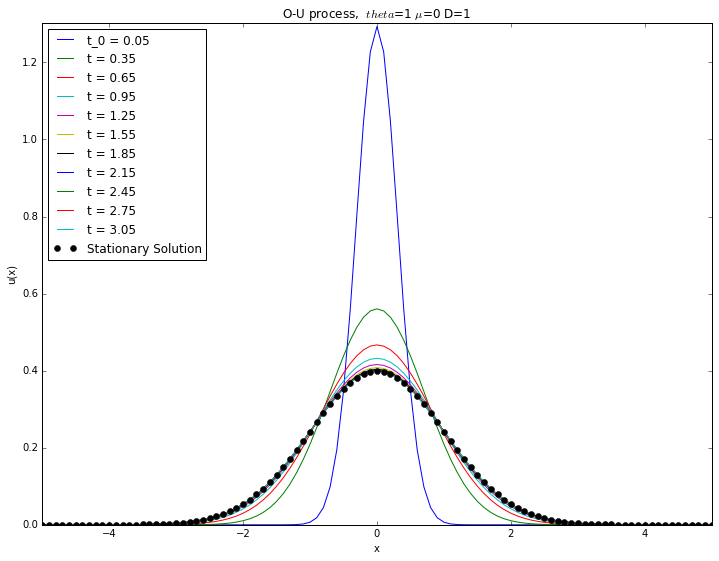

Error at end time:0.000604098298978


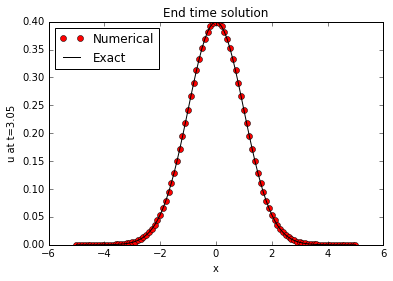

In [4]:
##test problems
a = -5.0
m=100
b = 5.0
dx = (b-a)/m
y = (a+b)/2
T = 3.0

n=600

t_0 = 0.05
theta = 1
mu = 0
D = 1

p,x = solve_OU(m, n, T, theta,mu,D,a,b,t_0)
t = t_0+T
#constant
c_t = theta / (2*D*np.pi*(1-np.exp(-2*theta*t)))
#true solution and stable solution
p_true = np.exp(-c_t*np.pi*(x-mu-np.exp(-theta*t)*(y-mu))**2 ) * np.sqrt(c_t)
p_sta = np.exp(-theta*(x-mu)**2/(2*D))*np.sqrt(theta/(2*D*np.pi))
print "Error at end time:"+str(np.linalg.norm(dx*abs(p-p_true),1))
plt.plot(x, p, 'ro',label='Numerical')
plt.plot(x, p_true, 'k',label='Exact')

plt.xlabel('x')
plt.ylabel('u at t='+str(t))
plt.legend(loc='upper left')
plt.title('End time solution')
plt.show()

### Error Analysis

In the next cell we run an order of accuracy analysis holding D = 1,$\theta = 1,\mu=0$,T = 1,t_0 = 0.05 and [a,b]=[-5,5]. We choose a number of 
$\Delta x$'s and use the corresponding $\Delta t = \frac{\Delta x^2}{2}$ developed earlier for respective $\Delta x$.

Using m=100
Time 0.15 probability total = 1.0
Time 0.25 probability total = 1.0
Time 0.35 probability total = 1.0
Time 0.45 probability total = 1.00000000009
Time 0.55 probability total = 1.00000000056
Time 0.65 probability total = 1.00000000156
Time 0.75 probability total = 1.00000000277
Time 0.85 probability total = 1.00000000404
Time 0.95 probability total = 1.00000000617
Time 1.05 probability total = 1.00000001099


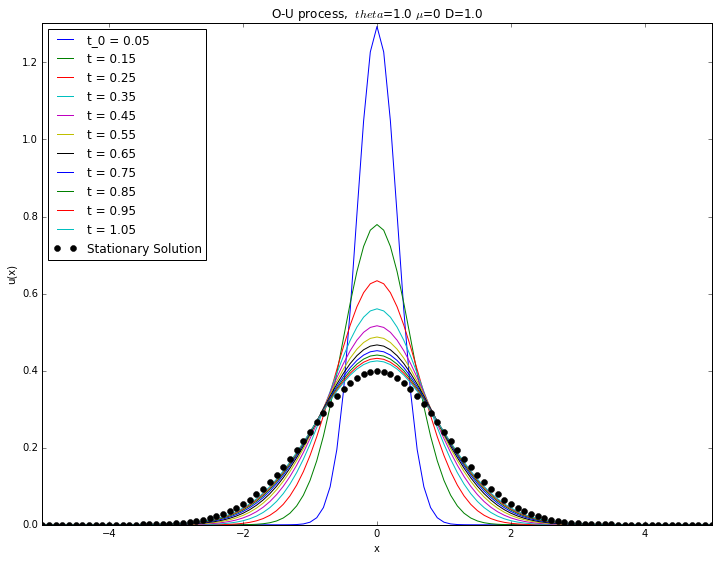

End time error: 0.00111519916415
Using m=200
Time 0.15 probability total = 1.0
Time 0.25 probability total = 1.0
Time 0.35 probability total = 1.0
Time 0.45 probability total = 0.999999999975
Time 0.55 probability total = 0.999999999568
Time 0.65 probability total = 0.999999997458
Time 0.75 probability total = 0.999999991501
Time 0.85 probability total = 0.999999979909
Time 0.95 probability total = 0.999999962273
Time 1.05 probability total = 0.999999939695


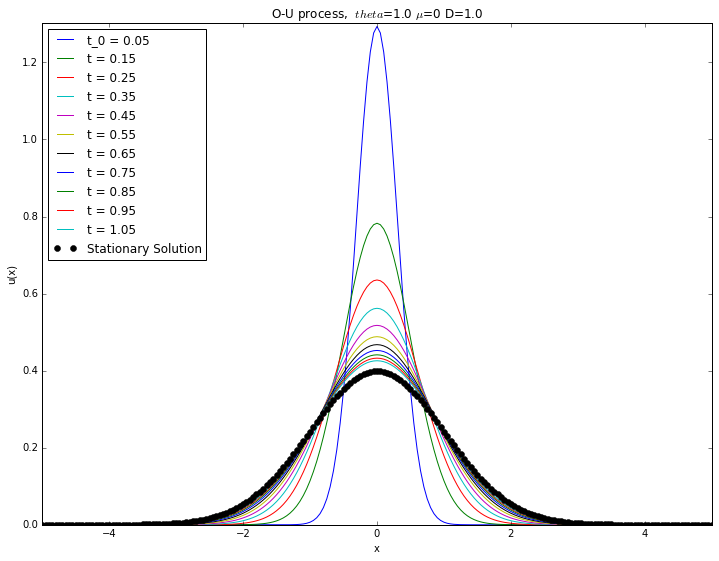

End time error: 0.000279038593958
Using m=300
Time 0.15 probability total = 1.0
Time 0.25 probability total = 1.0
Time 0.35 probability total = 0.999999999999
Time 0.45 probability total = 0.999999999946
Time 0.55 probability total = 0.999999999336
Time 0.65 probability total = 0.99999999652
Time 0.75 probability total = 0.99999998895
Time 0.85 probability total = 0.999999974489
Time 0.95 probability total = 0.999999952498
Time 1.05 probability total = 0.999999923976


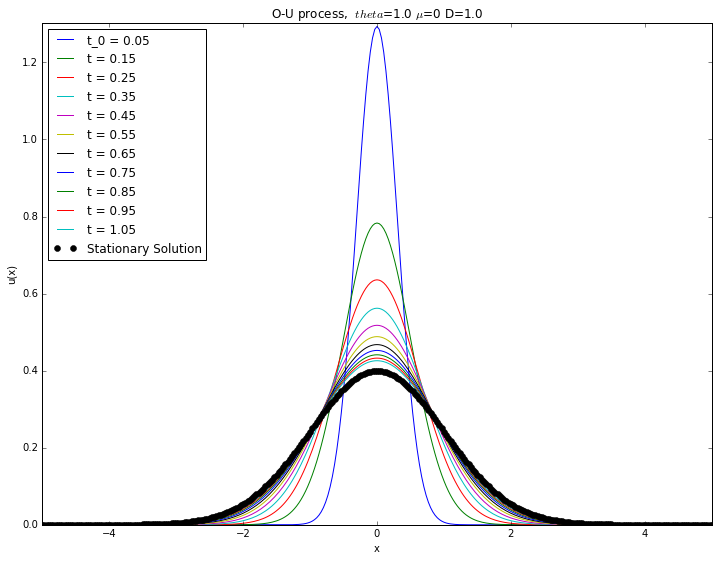

End time error: 0.000124025535487
Using m=400
Time 0.15 probability total = 1.0
Time 0.25 probability total = 1.0
Time 0.35 probability total = 0.999999999999
Time 0.45 probability total = 0.999999999935
Time 0.55 probability total = 0.999999999244
Time 0.65 probability total = 0.999999996147
Time 0.75 probability total = 0.999999987931
Time 0.85 probability total = 0.999999972324
Time 0.95 probability total = 0.999999948606
Time 1.05 probability total = 0.999999917747


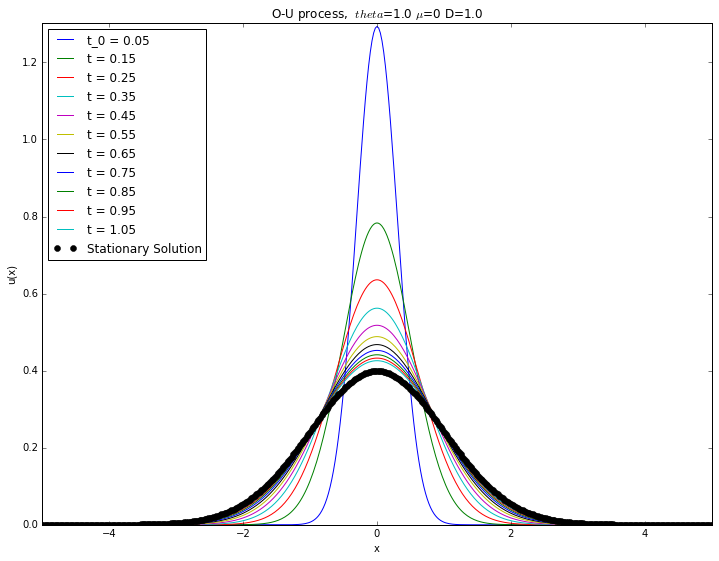

End time error: 6.97649574773e-05


In [5]:
a = -5.0
b = 5.0
y = (a+b)/2.0
theta = 1.0
mu = 0
D = 1.0
T = 1.0
t_0 = 0.05
t = T+t_0
delta_x = []
error = []
#error convergence study
for m in [100,200,300,400]:
    print "Using m="+str(m)
    n = int(2*T*m*m / 100)
    dx = (b-a) / m
    p,x = solve_OU(m, n, T, theta,mu, D, a, b,t_0)
    delta_x.append(dx)
    c_t = theta / (2*D*np.pi*(1-np.exp(-2*theta*t)))
#true solution and stable solution
    p_true = np.exp(-c_t*np.pi*(x-mu-np.exp(-theta*t)*(y-mu))**2 ) * np.sqrt(c_t)
    e = np.linalg.norm(dx*(p - p_true),ord=1)
    error.append(e)
    print "End time error: "+str(e)

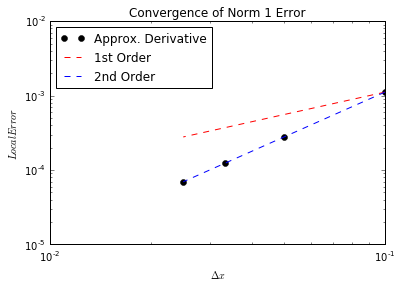

In [6]:
#run this cell after the previous cell is done
#plot error convergence
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
delta_x = np.array(delta_x)
error = np.array(error)
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")

order_C = lambda delta_x, error, order: np.exp(np.log(error) - order * np.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc='upper left')
axes.set_title("Convergence of Norm 1 Error")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$Local Error$")


plt.show()

Conclusion: The performance of our FTCS method on this O-U problem is second order accurate in $\Delta x$ and thus first order accurate in $\Delta t$.
This result is expected of this problem if we are working on an interval [-L,L] where L is not too large. So we can essentially bound the nonconstant 
part using the L constant, so that the problem has a LTE behavior pretty much alike that of a constan coefficient problem analyzed in the previous section.
We know that a FTCS method gives $O(\Delta x^2) = O(\Delta t)$ error in that case, so we would expect this result for this problem.

### Other Input Parameters

The function solve_OU() also solves problem with other kind of inputs. For example if we change to $\mu=3$ in the interval [a,b]=[0,10], we would have a drifting process as expected
(notice that the choice of m and n still satisfies stability condition with |x-$\mu$|<=7 bounded here):

Time 0.35 probability total = 1.00000000033
Time 0.65 probability total = 0.999999789994
Time 0.95 probability total = 0.999987767397
Time 1.25 probability total = 0.999933437551
Time 1.55 probability total = 0.999829720763
Time 1.85 probability total = 0.999696876572
Time 2.15 probability total = 0.999559366057
Time 2.45 probability total = 0.999433994983
Time 2.75 probability total = 0.999328869795
Time 3.05 probability total = 0.999246006466


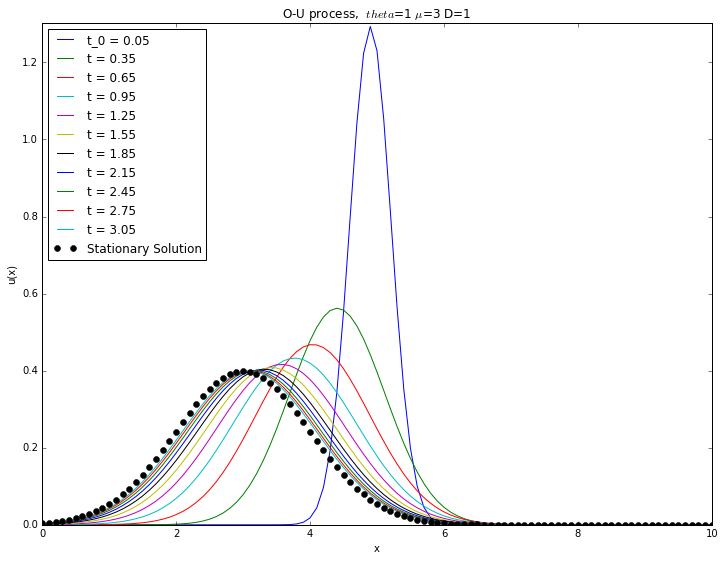

Error at end time:0.000699795222961


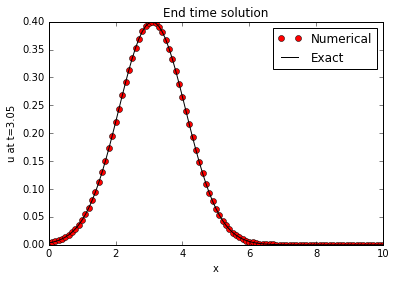

In [7]:
##test problems
a = -0.0
b = 10.0
m=100
dx = (b-a)/m
y = (a+b)/2
T = 3.0
n=600

t_0 = 0.05
theta = 1
mu = 3
D = 1

p,x = solve_OU(m, n, T, theta,mu,D,a,b,t_0)
t = t_0+T
#constant
c_t = theta / (2*D*np.pi*(1-np.exp(-2*theta*t)))
#true solution and stable solution
p_true = np.exp(-c_t*np.pi*(x-mu-np.exp(-theta*t)*(y-mu))**2 ) * np.sqrt(c_t)
p_sta = np.exp(-theta*(x-mu)**2/(2*D))*np.sqrt(theta/(2*D*np.pi))
print "Error at end time:"+str(np.linalg.norm(dx*abs(p-p_true),1))
plt.plot(x, p, 'ro',label='Numerical')
plt.plot(x, p_true, 'k',label='Exact')

plt.xlabel('x')
plt.ylabel('u at t='+str(t))
plt.legend(loc='upper right')
plt.title('End time solution')
plt.show()

# Extension to 2D and Other Future Perspectives

We have developed methods and analyzed their performances on various one dimensional FPE family of problems.
The methods can usually be generalized to higher dimensions.
For example, if we are working with a FPE in 2D with x and y coordinates, let p(x,y,t) represent the probability distribution, the original equation representation will be modified as :
$$
{\frac {\partial }{\partial t}}p(x,y,t)=-{\frac {\partial }{\partial x}}\left[\mu_1 (x,y,t)p(x,y,t)\right]-{\frac {\partial }{\partial y}}\left[\mu_2 (x,y,t)p(xy,t)\right]+{\frac{1}{2}\frac {\partial ^{2}}{\partial x^{2}}}\left[D_1(x,y,t)p(x,y,t)\right]+{\frac{1}{2}\frac {\partial ^{2}}{\partial y^{2}}}\left[D_2(x,y,t)p(x,y,t)\right]$$.    

## 2D Constant Coefficient Problems

Here we have four functional coefficients $\mu_1,\mu_2,D_1,D_2$. 
As for a simple case study we can consider constant coefficients and using $D_1=D_2=D$ so the diffusion is simultaneous
for both coordinate direction. Let u(x,y,t) represent the probability function in our numerical study.
Starting with $u(x,y,0) = \frac{1}{2\pi}e^{-(x^2+y^2)/2}$ an origin centered 2D standard normal distribution, our true solution should be:
$$u(x,y,t) =  \frac{1}{2\pi+2\pi Dt}e^{-((x-\mu_1 t)^2+(y-\mu_2 t)^2)/(2+2Dt)}$$

In our numerical method, we can use the explicit FTCS method to get us started with this problem. Hopefully we are working with a square domain
for example [-5,5]X[-5,5].We can fix $\Delta x=\Delta y$ so that the order of accuracy is consistent. The general numerical scheme is to approximate
each derivative with a centered approximation.

In [22]:
def solve_fpe_2d(m, N, T, u_1, u_2, D, a, b):
     """
    This function solves a constant coefficient 2D fpe with drag coefficient u_1,u_2 and identical
    diffusion coefficient D using explicit FTCS method.
    The spatial domain is [a,b]X[a,b] and the time range is [0,T]
    m grids and N steps are used for spatial and time discretizations.
    The funciton returns the end time numerical and true solution U,U_true and the spatial arrays x,y.
    """
    y = np.linspace(a, b, m+1)
    x = np.linspace(a, b, m+1)
    delta_x = float(b - a) / m
    delta_t = float(T) / N
    mean = (a + b)/2.0
    t_0 = 1.0 / D
    p_0 = lambda x,y: np.exp(-(x**2+y**2) / 2) / (2*np.pi)
    p_true = lambda x,y,t: np.exp(-((x-u_1*t)**2+(y-u_2*t)**2) / (2+2*D*t)) / (2*np.pi+2*np.pi*D*t)
    t =0.0
    U = np.zeros((m+1,m+1))
    for i in range(m+1):
        for j in range(m+1):
            U[i,j] = p_0(x[i],y[j])
    for n in range(1,N+1):    
        t = n*delta_t
        U_old = U.copy()
        for i in range(1,m):
            for j in range(1,m):
            #centered difference
                U[i][j] = (-u_1*(U_old[i+1][j]-U_old[i-1][j])/(2*delta_x)-u_2*(U_old[i][j+1]-U_old[i][j-1])/(2*delta_x))*delta_t
                U[i][j] += (D*0.5*(U_old[i+1][j]+U_old[i-1][j]-2*U_old[i][j]+U_old[i][j+1]+U_old[i][j-1]-2*U_old[i][j])/delta_x**2)*delta_t + U_old[i][j]
        #boundary conditions set to be true solution
        for j in range(m+1):
            U[0][j] = p_true(a,y[j],t)
            U[-1][j] = p_true(b,y[j],t)
        for i in range(m+1):
            U[i][0] = p_true(x[i],a,t)
            U[i][-1] = p_true(x[i],b,t)   
    U_true = np.zeros((m+1,m+1))
    for i in range(m+1):
        for j in range(m+1):
            U_true[i][j] = p_true(x[i],y[j],T)
    
    return U,U_true, x, y

In this test problem we have $\mu_1=\mu_2=1,D=1,m=100,n=100,T=0.5$ starting at the origin.
So the end time solution should be a normal centered at (1,1). The end time error is 4e-4 and it is expected to be second order accurate in $\Delta x=\Delta y$

The reason is that both direction have second order approximations and from the 1D case we studied before, the error behaves in second order accuracy 
of $\Delta x$ for the x direction, and since now $\Delta x=\Delta y$, the errors can be combined into $O(\Delta x^2)$


In [26]:
#test probelm
a=-5.0
b=5.0
L = b-a
m = 100
dx = L/m
n = 100
T = 0.5
u_1 = 1.0
u_2 = 1.0
D = 1.0
U,U_true,x ,y = solve_fpe_2d(m,n,T,u_1,u_2,D,a,b)


In [27]:
print "Using m=100:"
print "End time sum of probability:"+str(sum(sum(U))*dx**2)
print "Error at end time:"+str(np.linalg.norm(dx*(U-U_true),ord=1))

Using m=100:
End time sum of probability:0.999802837168
Error at end time:0.000397366187376


Within the range of stable $\Delta x$ choices we can run an order of accuracy study with m=[50,60,70,80,90,100] points and the choice of 
$\Delta t = \frac{\Delta x^2}{2D}$ for which the reasoning we give in the concluding paragraph. Here with D=1, and T=0.5, our choice of number of time steps n is $n = \frac{m^2}{100}$. The result confirms that the method is second order accurate in $\Delta x$, thus first order accurate in $\Delta t$.

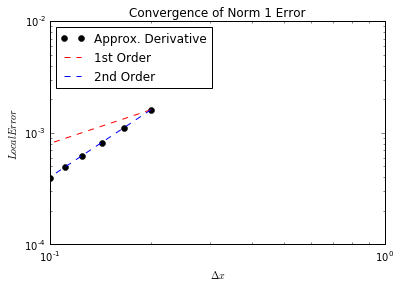

In [28]:
a=-5.0
b=5.0
L = b-a
u_1 = 1.0
u_2 = 1.0
D = 1.0
T = 0.5
delta_x=[]
error=[]
#error convergence plot
for m in [50,60,70,80,90,100]:
    dx = L/m
    delta_x.append(dx)
    n = m*m/100
    U,U_true,x,y = solve_fpe_2d(m,n,T,u_1,u_2,D,a,b)
    error.append(np.linalg.norm(dx*(U-U_true),ord=1))
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
delta_x = np.array(delta_x)
error = np.array(error)
axes.loglog(delta_x, error, 'ko', label="Approx. Derivative")
order_C = lambda delta_x, error, order: np.exp(np.log(error) - order * np.log(delta_x))
axes.loglog(delta_x, order_C(delta_x[0], error[0], 1.0) * delta_x**1.0, 'r--', label="1st Order")
axes.loglog(delta_x, order_C(delta_x[0], error[0], 2.0) * delta_x**2.0, 'b--', label="2nd Order")
axes.legend(loc='upper left')
axes.set_title("Convergence of Norm 1 Error")
axes.set_xlabel("$\Delta x$")
axes.set_ylabel("$Local Error$")

plt.show()

Using our intuition from the 1D problem where we used Von Neumann analysis to characterize the stability condition, here we have two second derivatives 
adding together so the choice of $\Delta t = \frac{\Delta x^2}{2D}$ should give us stability when $\mu_1,\mu_2$ are small. Notice that our test problem discretization
satisfies this condition. Violating the condition (for example having T=1 in the above example would give unbounded errors.

## Future Perspectives

Much of the similar kind of methods we developed can be therefore generalized in 2D and this will be left as a future perspective of the project.
Other future perspectives include but not restricted to:
    
-Other forms of implicit Difference Methods such as Crank-Nicholson

-Finite Element Method for the entire family of FPE problems

-Finite Element Method in 2D

-Higher Dimension Generalizations


# References:



-NUMERICAL SOLUTION OF THE FOKKER-PLANCK EQUATION BY FINITE DIFFERENCE AND FINITE ELEMENT METHODS-A COMPARATIVE STUDY
L.Pichler,A.Masud, L.A.Bergman

-https://en.wikipedia.org/wiki/Fokker–Planck_equation

-https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process

-Online Resource: Codes from https://people.sc.fsu.edu/~jburkardt/py_src.html

-Class Materials from Github: https://github.com/mandli/numerical-methods-pdes